#### Projekat "___Metode za augmentaciju teksta: Istrazivanje razlicitih tehnika i njihov uticaj na performanse klasifikacionih modela i dubokih neuronskih mreža___"                              iz predmeta __Obrada prirodnih jezika__

__Nastasija Stankovic 1622__

Dataset: https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset

Opis:
Ovaj skup podataka sadrži tvitove koji se odnose na temu klimatskih promena, sakupljene u periodu od 27. aprila 2015. do 21. februara 2018. Ukupno je anotirano 43.943 tvitova, pri čemu je svaki tvit pregledan od strane 3 recenzenta. U ovom skupu podataka su zadržani samo tvitovi na koje su se svi recenzenti složili, dok su ostali odbačeni.     

Svaki tvit je svrstan u jednu od sledećih kategorija:    

__2 (Vesti)__: tvitovi koji sadrže linkove ka činjenicama o klimatskim promenama    
__1 (Pro)__: tvitovi koji podržavaju verovanje da su klimatske promene rezultat ljudskih aktivnosti    
__0 (Neutralno)__: tvitovi koji ne podržavaju niti osporavaju verovanje u antropogene klimatske promene    
__-1 (Anti)__: tvitovi koji ne veruju u antropogene klimatske promene     

In [3]:
import gensim
import transformers
import sacremoses
import torch
import gensim.downloader as api
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from nlpaug.util import Action
import nltk
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

In [4]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [14]:
data = pd.read_csv('twitter_sentiment_data.csv')

In [15]:
print("Shape:",data.shape)
data.head(10)

Shape: (43943, 3)


,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153
5,0,Unamshow awache kujinga na iko global warming ...,793125429418815489
6,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125430236684289
7,2,RT @CCIRiviera: Presidential Candidate #Donald...,793126558688878592
8,0,RT @AmericanIndian8: Leonardo DiCaprio's clima...,793127097854197761
9,1,#BeforeTheFlood Watch #BeforeTheFlood right he...,793127346106753028


In [16]:
data = data.rename(columns = {"sentiment": "label", "message": "text"}).drop('tweetid', axis = 1)

In [17]:
data['label'] = data['label'].replace([-1, 0, 1, 2],[0, 1, 2, 3])

In [18]:
data.dtypes

label     int64
text     object
dtype: object

In [19]:
data.isna().sum()

label    0
text     0
dtype: int64

<Figure size 700x500 with 0 Axes>

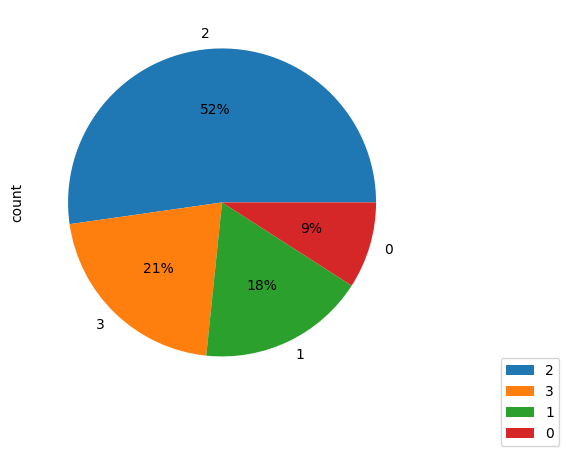

In [11]:
plt.figure(figsize=(7, 5))
pie = data.label.value_counts().plot(kind='pie', autopct='%1.0f%%')
pie.figure.set_size_inches(7, 5)
pie.figure.legend(loc='lower right')
plt.show()

In [20]:
data_label_2 = data[data['label'] == 2]
num_rows_to_drop = int(0.7 * len(data_label_2))
rows_to_drop = np.random.choice(data_label_2.index, size=num_rows_to_drop, replace=False)

data.drop(rows_to_drop, inplace=True)

In [21]:
data.shape

(27870, 2)

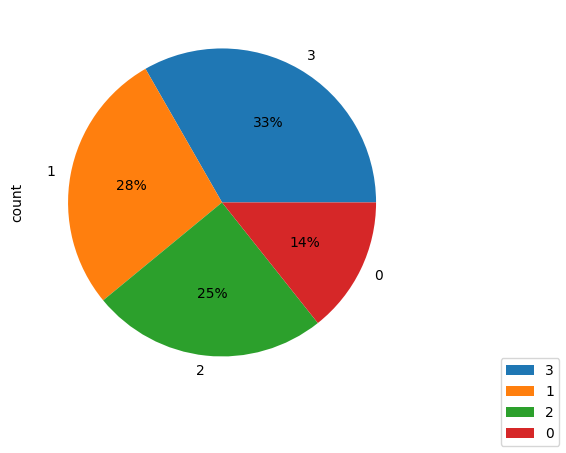

In [ ]:
plt.figure(figsize=(7, 5))
pie = data.label.value_counts().plot(kind='pie', autopct='%1.0f%%')
pie.figure.set_size_inches(7, 5)
pie.figure.legend(loc='lower right')
plt.show()

In [22]:
data_label_3 = data[data['label'] == 3]
num_rows_to_drop = int(0.2 * len(data_label_3))
rows_to_drop = np.random.choice(data_label_3.index, size=num_rows_to_drop, replace=False)

data.drop(rows_to_drop, inplace=True)

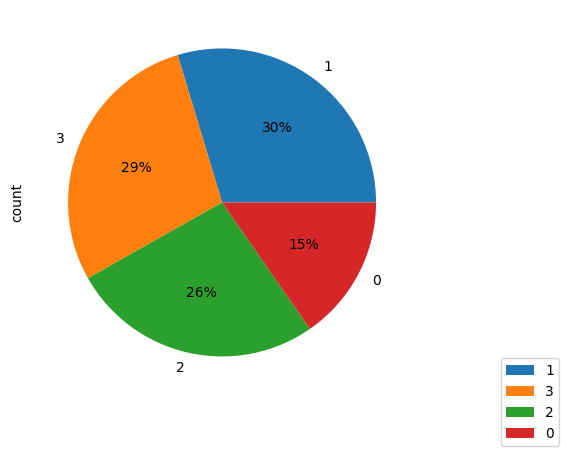

In [ ]:
plt.figure(figsize=(7, 5))
pie = data.label.value_counts().plot(kind='pie', autopct='%1.0f%%')
pie.figure.set_size_inches(7, 5)
pie.figure.legend(loc='lower right')
plt.show()

In [23]:
data.shape

(26015, 2)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
  data['text'], data['label'], test_size = 0.2)
X_train.shape, X_test.shape

((20812,), (5203,))

In [25]:
def preprocessor(text):

  text = re.sub('<[^>]*>', '', text)
  text = re.sub(r"@[^\s]+",'', text)
  text = re.sub('http[^\s]+', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
  return text

In [26]:
X_train = X_train.apply(preprocessor)
X_test = X_test.apply(preprocessor)

pd.DataFrame(X_train[:5])

,text
13085,rt how we re waking climate change s sleeping ...
24428,rt the wine industry in europe could be in tro...
39849,rt climate change has been the ultimate threat...
19922,rt the most polarized on the issue of climate ...
538,in 4 days the most ambitious climate change ag...


In [27]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
print(stop_words)
print(len(stop_words))

{"couldn't", 'the', 'that', 'didn', 'ours', "you've", 'yourselves', 'shouldn', 'mightn', 'hers', 'until', 'it', 'you', "mightn't", 'once', "wasn't", 'most', "hadn't", 'any', 'few', 'who', 'how', "doesn't", 'with', 've', "won't", 'was', 'out', 'haven', 'needn', 'doesn', 'both', 'in', 'all', 'he', 'does', 'itself', 'hadn', 'their', 'wasn', 'here', "you're", 'into', 'or', 'be', 'has', 'ourselves', 'through', "isn't", 'won', 'on', "should've", 'so', 'more', 'its', "didn't", 'hasn', 'your', 'which', 'over', "she's", 'other', 'm', 'can', 'up', 'same', 'nor', 'being', 'only', 'myself', 'couldn', "hasn't", "haven't", 'weren', 'not', 'against', 'each', 'd', 'her', 'we', 'they', 'shan', 'if', 'as', 'i', 'between', 'then', 'during', 'because', 'than', "you'd", 'will', 'just', 'mustn', 'ma', 'why', 'where', "you'll", 'an', 'whom', 'of', 'when', 're', 'herself', 'are', 'don', 'them', 'she', 'had', 'themselves', 'what', 'wouldn', "shouldn't", 't', 'to', 'were', 'off', 'theirs', 'our', 'yourself', 'a

In [28]:
def tokenizer_lemmetizer(text):

  text = tokenizer.tokenize(text)

  text = [token for token in text if token not in stop_words]

  return ' '.join([lemmatizer.lemmatize(word) for word in text])

In [29]:
X_train = X_train.apply(tokenizer_lemmetizer)
X_test = X_test.apply(tokenizer_lemmetizer)

In [30]:
count = CountVectorizer(

  stop_words = 'english',
  ngram_range = (1, 1),
  max_features = 10000)

In [31]:
X_train_bag = count.fit_transform(X_train)
print(X_train_bag.shape)

X_test_bag = count.transform(X_test)
print(X_test_bag.shape)

(20812, 10000)
(5203, 10000)


In [32]:
tfidf = TfidfTransformer(use_idf = True, norm = 'l2', smooth_idf = True)
X_train_tfidf = tfidf.fit_transform(X_train_bag)
X_test_tfidf = tfidf.transform(X_test_bag)

In [ ]:
print(X_train_tfidf.toarray())
print('\n')
X_train_tfidf.toarray().shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]




(20812, 10000)

Without augmentation

In [33]:
models = {
    "Multinomial Naive Bayes": MultinomialNB()
}

In [37]:
def without_aug(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.628483567172785
Confusion Matrix:


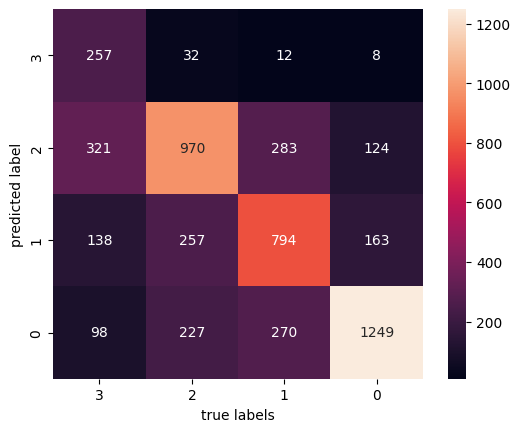


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.32      0.46       814
           1       0.57      0.65      0.61      1486
           2       0.59      0.58      0.59      1359
           3       0.68      0.81      0.74      1544

    accuracy                           0.63      5203
   macro avg       0.67      0.59      0.60      5203
weighted avg       0.65      0.63      0.62      5203





In [ ]:
for model_name, model in models.items():
    cm, cr,acc = without_aug(model, X_train_tfidf, y_train, X_test_tfidf, y_test)
    print(f"Model: {model_name}")

    print("Accuracy: {}".format(acc))

    print("Confusion Matrix:")
    sns.heatmap(cm.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr)
    print("\n")

### Character augmenter

##### OCR Augmenter

In [38]:
aug1 = nac.OcrAug()

In [39]:
def evaluate_aug1(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug1.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy


Model: Multinomial Naive Bayes
Accuracy: 0.6373246204113012
Confusion Matrix:


<Axes: >

Text(0.5, 23.52222222222222, 'true labels')

Text(77.92222222222227, 0.5, 'predicted label')

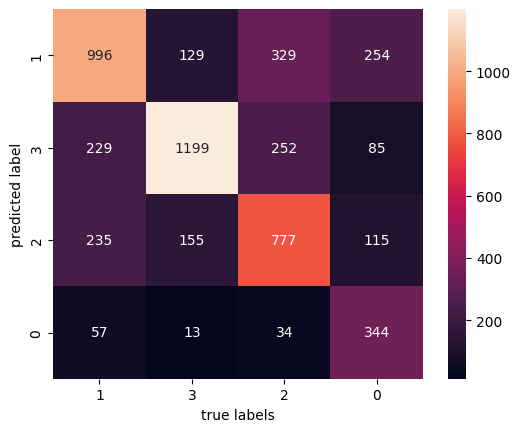


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.43      0.55       798
           1       0.58      0.66      0.62      1517
           2       0.61      0.56      0.58      1392
           3       0.68      0.80      0.74      1496

    accuracy                           0.64      5203
   macro avg       0.66      0.61      0.62      5203
weighted avg       0.65      0.64      0.63      5203





In [40]:
for model_name, model in models.items():
    cm1, cr1,acc1 = evaluate_aug1(model,1, X_train, y_train, X_test, y_test,'OCR_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc1))
    print("Confusion Matrix:")
    sns.heatmap(cm1.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr1)
    print("\n")

##### Keyboard Augmenter

In [ ]:
aug2 = nac.KeyboardAug()

In [ ]:
def evaluate_aug2(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug2.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.6275225831251201
Confusion Matrix:


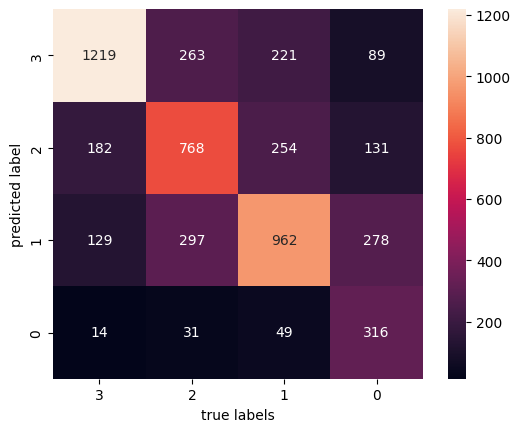


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.39      0.52       814
           1       0.58      0.65      0.61      1486
           2       0.58      0.57      0.57      1359
           3       0.68      0.79      0.73      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.60      0.61      5203
weighted avg       0.64      0.63      0.62      5203





In [ ]:
for model_name, model in models.items():
    cm2, cr2,acc2 = evaluate_aug2(model,1, X_train, y_train, X_test, y_test,'Keyboard_augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc2))
    print("Confusion Matrix:")
    sns.heatmap(cm2.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr2)
    print("\n")

##### Random Augmenter

In [ ]:
augr1 = nac.RandomCharAug(action="insert")
augr2 = nac.RandomCharAug(action="substitute")
augr3 = nac.RandomCharAug(action="swap")
augr4 = nac.RandomCharAug(action="delete")

In [ ]:
def evaluate_aug3(model,aug_strategy, n, X_train, y_train, X_test, y_test,output_file):

  original_sentences = []
  augmented_tweets = []
  augmented_tweets_labels = []

  for i in X_train.index:
    if aug_strategy == 'insert':
      lst_augment = augr1.augment(X_train[i], n = n)
    elif aug_strategy == 'substitute':
      lst_augment = augr2.augment(X_train[i], n = n)
    elif aug_strategy == 'swap':
      lst_augment = augr3.augment(X_train[i], n = n)
    else:
      lst_augment = augr4.augment(X_train[i], n = n)

    for augment in lst_augment:
        original_sentences.append(X_train[i])
        augmented_tweets.append(augment)
        augmented_tweets_labels.append(y_train[i])

  df = pd.DataFrame({
      'Original sentence': original_sentences,
      'Augmented sentence': augmented_tweets
  })

  df.to_csv(output_file, index=False)

  X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
  y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

  X_train_appended = X_train_appended.apply(preprocessor)

  X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)


  X_train_appended_bag = count.fit_transform(X_train_appended)
  X_test_bag = count.transform(X_test)

  X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
  X_test_tfidf = tfidf.transform(X_test_bag)

  augmented_tweets.clear()
  augmented_tweets_labels.clear()

  model.fit(X_train_appended_tfidf, y_train_appended)
  y_pred = model.predict(X_test_tfidf)
  cm = confusion_matrix(y_test, y_pred,labels=y_test.unique())
  cr = classification_report(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)

  return cm, cr,accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.6336728810301749
Confusion Matrix:


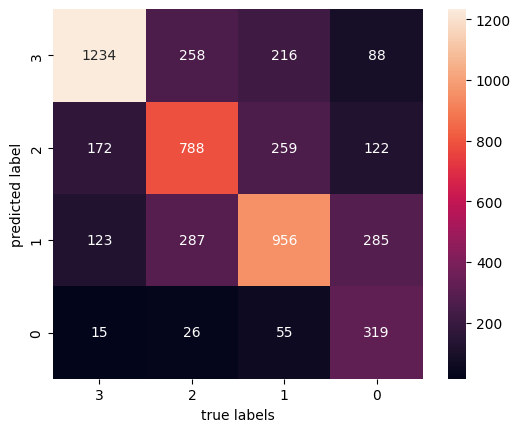


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.39      0.52       814
           1       0.58      0.64      0.61      1486
           2       0.59      0.58      0.58      1359
           3       0.69      0.80      0.74      1544

    accuracy                           0.63      5203
   macro avg       0.66      0.60      0.61      5203
weighted avg       0.64      0.63      0.63      5203





In [ ]:
for model_name, model in models.items():
    cmr1, crr1,accr1 = evaluate_aug3(model, 'insert', 1, X_train, y_train, X_test, y_test,'RandomCharInsert_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(accr1))
    print("Confusion Matrix:")
    sns.heatmap(cmr1.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(crr1)
    print("\n")

Model: Multinomial Naive Bayes
Accuracy: 0.633288487411109
Confusion Matrix:


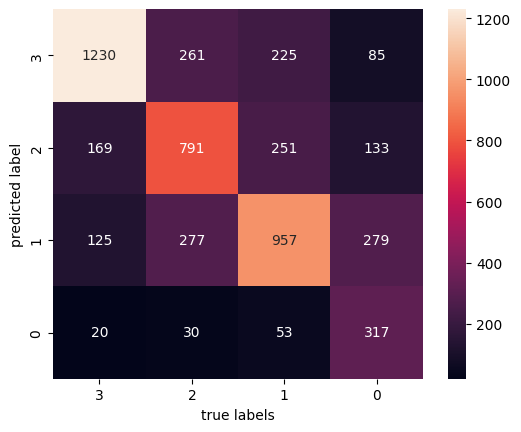


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.39      0.51       814
           1       0.58      0.64      0.61      1486
           2       0.59      0.58      0.59      1359
           3       0.68      0.80      0.74      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.60      0.61      5203
weighted avg       0.64      0.63      0.63      5203





In [ ]:
for model_name, model in models.items():
    cmr2, crr2,accr2 = evaluate_aug3(model, 'substitute', 1, X_train, y_train, X_test, y_test,'RandomCharSub_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(accr2))
    print("Confusion Matrix:")
    sns.heatmap(cmr2.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(crr2)
    print("\n")

Model: Multinomial Naive Bayes
Accuracy: 0.6346338650778397
Confusion Matrix:


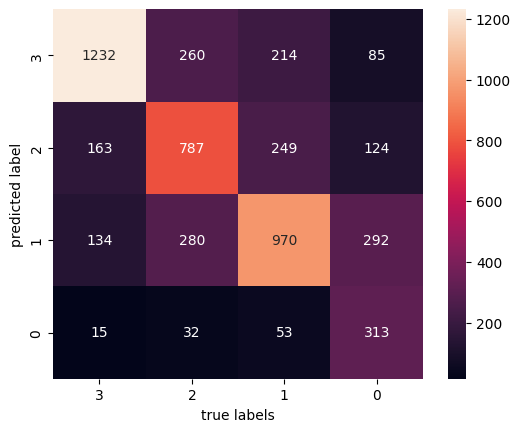


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.38      0.51       814
           1       0.58      0.65      0.61      1486
           2       0.59      0.58      0.59      1359
           3       0.69      0.80      0.74      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.60      0.61      5203
weighted avg       0.64      0.63      0.63      5203





In [ ]:
for model_name, model in models.items():
    cmr3, crr3,accr3 = evaluate_aug3(model, 'swap', 1, X_train, y_train, X_test, y_test,'RandomCharSwap_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(accr3))
    print("Confusion Matrix:")
    sns.heatmap(cmr3.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(crr3)
    print("\n")

Model: Multinomial Naive Bayes
Accuracy: 0.628483567172785
Confusion Matrix:


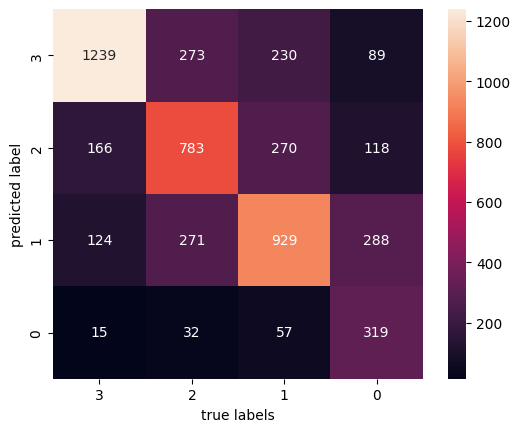


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.39      0.52       814
           1       0.58      0.63      0.60      1486
           2       0.59      0.58      0.58      1359
           3       0.68      0.80      0.73      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.60      0.61      5203
weighted avg       0.64      0.63      0.62      5203





In [ ]:
for model_name, model in models.items():
    cmr4, crr4,accr4 = evaluate_aug3(model, 'delete', 1, X_train, y_train, X_test, y_test,'RandomCharDelete_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(accr4))
    print("Confusion Matrix:")
    sns.heatmap(cmr4.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(crr4)
    print("\n")

#### Word augmenter

##### Spelling Augmenter

In [ ]:
aug4 = naw.SpellingAug()

In [ ]:
def evaluate_aug4(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug4.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.6302133384585816
Confusion Matrix:


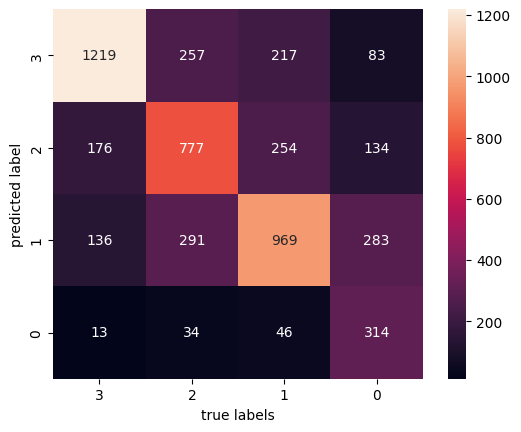


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.39      0.51       814
           1       0.58      0.65      0.61      1486
           2       0.58      0.57      0.58      1359
           3       0.69      0.79      0.73      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.60      0.61      5203
weighted avg       0.64      0.63      0.62      5203





In [ ]:
for model_name, model in models.items():
    cm4, cr4,acc4 = evaluate_aug4(model,1, X_train, y_train, X_test, y_test,'Spelling_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc4))
    print("Confusion Matrix:")
    sns.heatmap(cm4.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr4)
    print("\n")

##### Synonym Augmenter

##### Substitute word by WordNet's synonym

In [ ]:
aug6 = naw.SynonymAug(aug_src='wordnet')

In [ ]:
def evaluate_aug6(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug6.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.6309821256967134
Confusion Matrix:


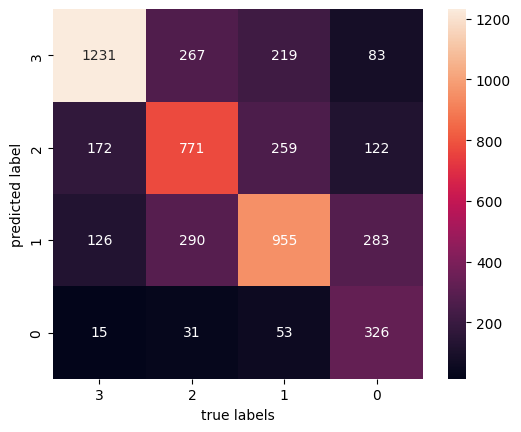


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.40      0.53       814
           1       0.58      0.64      0.61      1486
           2       0.58      0.57      0.57      1359
           3       0.68      0.80      0.74      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.60      0.61      5203
weighted avg       0.64      0.63      0.62      5203





In [ ]:
for model_name, model in models.items():
    cm6, cr6,acc6 = evaluate_aug6(model,1, X_train, y_train, X_test, y_test,'WordNetSynonym_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc6))
    print("Confusion Matrix:")
    sns.heatmap(cm6.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr6)
    print("\n")

##### Antonym Augmenter

In [ ]:
aug7 = naw.AntonymAug()

In [ ]:
def evaluate_aug7(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug7.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.6313665193157794
Confusion Matrix:


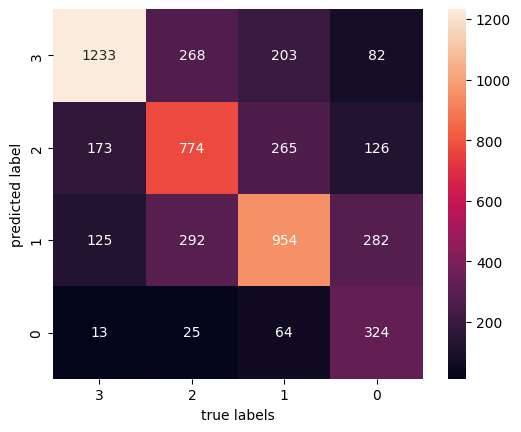


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.40      0.52       814
           1       0.58      0.64      0.61      1486
           2       0.58      0.57      0.57      1359
           3       0.69      0.80      0.74      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.60      0.61      5203
weighted avg       0.64      0.63      0.63      5203





In [ ]:
for model_name, model in models.items():
    cm7, cr7,acc7 = evaluate_aug7(model,1, X_train, y_train, X_test, y_test,'Antonym_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc7))
    print("Confusion Matrix:")
    sns.heatmap(cm7.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr7)
    print("\n")

##### Random Word Augmenter

Swap word randomly

In [ ]:
aug8 = naw.RandomWordAug(action="swap")

In [ ]:
def evaluate_aug8(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug8.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.6352104555064386
Confusion Matrix:


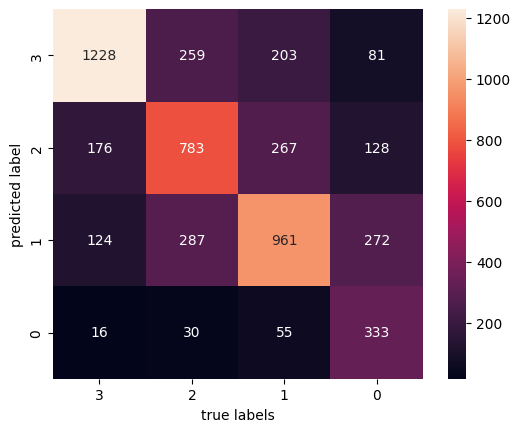


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.41      0.53       814
           1       0.58      0.65      0.61      1486
           2       0.58      0.58      0.58      1359
           3       0.69      0.80      0.74      1544

    accuracy                           0.64      5203
   macro avg       0.66      0.61      0.62      5203
weighted avg       0.64      0.64      0.63      5203





In [ ]:
for model_name, model in models.items():
    cm8, cr8,acc8 = evaluate_aug8(model,1, X_train, y_train, X_test, y_test,'SwapWord_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc8))
    print("Confusion Matrix:")
    sns.heatmap(cm8.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr8)
    print("\n")

Delete word randomly

In [ ]:
aug9 = naw.RandomWordAug(action='delete')

In [ ]:
def evaluate_aug9(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug9.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.6315587161253123
Confusion Matrix:


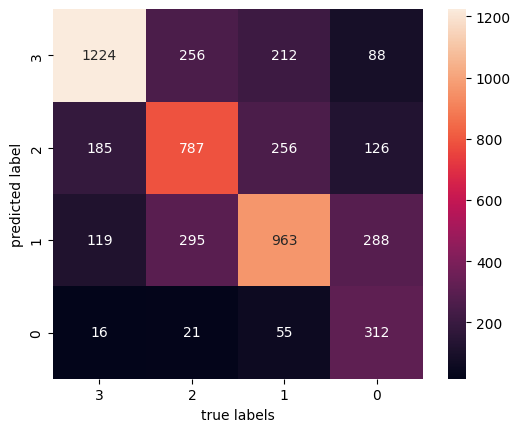


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.38      0.51       814
           1       0.58      0.65      0.61      1486
           2       0.58      0.58      0.58      1359
           3       0.69      0.79      0.74      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.60      0.61      5203
weighted avg       0.64      0.63      0.62      5203





In [ ]:
for model_name, model in models.items():
    cm9, cr9,acc9 = evaluate_aug9(model,1, X_train, y_train, X_test, y_test,'DeleteWord_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc9))
    print("Confusion Matrix:")
    sns.heatmap(cm9.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr9)
    print("\n")

##### Split Augmenter

In [ ]:
aug11 = naw.SplitAug()

In [ ]:
def evaluate_aug11(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug11.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.6292523544109168
Confusion Matrix:


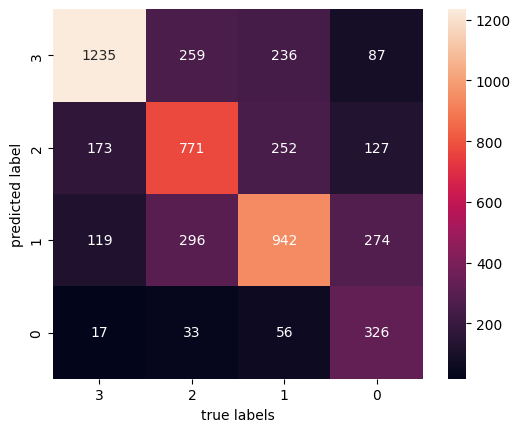


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.40      0.52       814
           1       0.58      0.63      0.60      1486
           2       0.58      0.57      0.57      1359
           3       0.68      0.80      0.73      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.60      0.61      5203
weighted avg       0.64      0.63      0.62      5203





In [ ]:
for model_name, model in models.items():
    cm11, cr11,acc11 = evaluate_aug11(model,1, X_train, y_train, X_test, y_test,'SplitWord_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc11))
    print("Confusion Matrix:")
    sns.heatmap(cm11.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr11)
    print("\n")

##### Contextual Word Embeddings Augmenter

Insert word by contextual word embeddings (BERT, DistilBERT, RoBERTA or XLNet)

In [ ]:
aug12 = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

In [ ]:
def evaluate_aug12(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug12.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.633480684220642
Confusion Matrix:


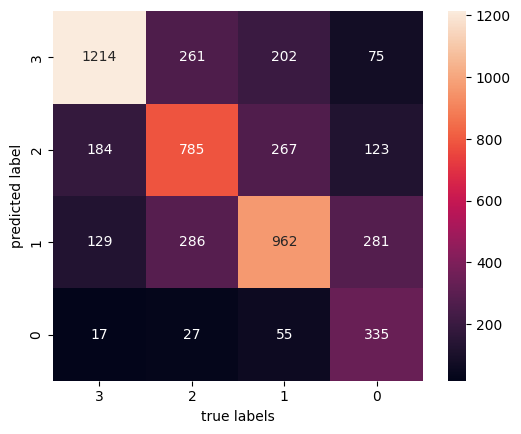


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.41      0.54       814
           1       0.58      0.65      0.61      1486
           2       0.58      0.58      0.58      1359
           3       0.69      0.79      0.74      1544

    accuracy                           0.63      5203
   macro avg       0.66      0.61      0.62      5203
weighted avg       0.64      0.63      0.63      5203





In [ ]:
for model_name, model in models.items():
    cm12, cr12,acc12 = evaluate_aug12(model,1, X_train, y_train, X_test, y_test,'BertWord_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc12))
    print("Confusion Matrix:")
    sns.heatmap(cm12.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr12)
    print("\n")

Substitute word by contextual word embeddings (BERT, DistilBERT, RoBERTA or XLNet)

In [ ]:
aug13 = naw.ContextualWordEmbsAug(model_path='roberta-base', action="substitute")

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
def evaluate_aug13(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug13.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.6265615990774553
Confusion Matrix:


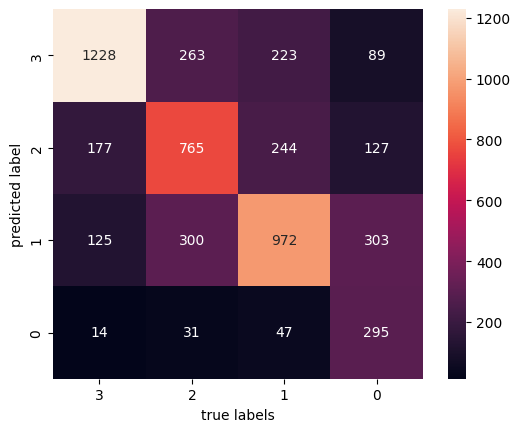


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.36      0.49       814
           1       0.57      0.65      0.61      1486
           2       0.58      0.56      0.57      1359
           3       0.68      0.80      0.73      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.59      0.60      5203
weighted avg       0.64      0.63      0.62      5203





In [ ]:
for model_name, model in models.items():
    cm13, cr13,acc13 = evaluate_aug13(model,1, X_train, y_train, X_test, y_test,'RobertaWord_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc13))
    print("Confusion Matrix:")
    sns.heatmap(cm13.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr13)
    print("\n")

#### Flow

To make use of multiple augmentation, sequential and sometimes pipelines are introduced to connect augmenters.

##### Sequential pipeline

In [ ]:
aug14 = naf.Sequential([
    nac.RandomCharAug(action="insert"),
    naw.RandomWordAug()
])

In [ ]:
def evaluate_aug14(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug14.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.628675763982318
Confusion Matrix:


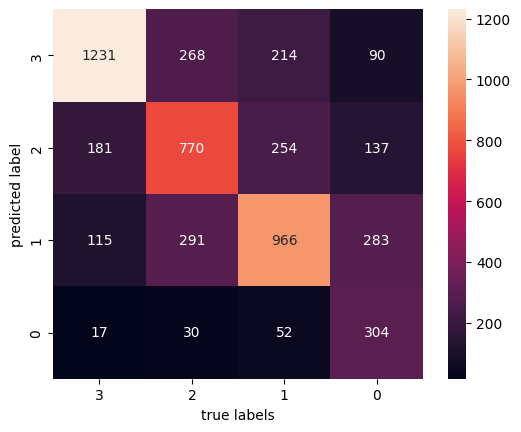


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.37      0.50       814
           1       0.58      0.65      0.62      1486
           2       0.57      0.57      0.57      1359
           3       0.68      0.80      0.74      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.60      0.61      5203
weighted avg       0.64      0.63      0.62      5203





In [ ]:
for model_name, model in models.items():
    cm14, cr14,acc14 = evaluate_aug14(model,1, X_train, y_train, X_test, y_test,'FlowSequential_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc14))
    print("Confusion Matrix:")
    sns.heatmap(cm14.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr14)
    print("\n")

##### Sometimes pipeline

In [ ]:
aug15 = naf.Sometimes([
    nac.RandomCharAug(action="delete"),
    nac.RandomCharAug(action="insert"),
    naw.RandomWordAug()
])

In [ ]:
def evaluate_aug15(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug15.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.6261772054583894
Confusion Matrix:


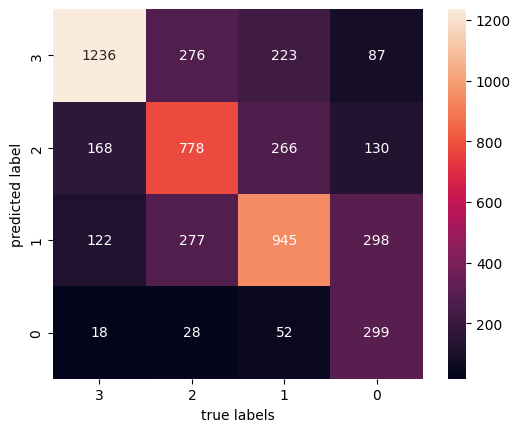


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.37      0.49       814
           1       0.58      0.64      0.60      1486
           2       0.58      0.57      0.58      1359
           3       0.68      0.80      0.73      1544

    accuracy                           0.63      5203
   macro avg       0.65      0.59      0.60      5203
weighted avg       0.63      0.63      0.62      5203





In [ ]:
for model_name, model in models.items():
    cm15, cr15,acc15 = evaluate_aug15(model,1, X_train, y_train, X_test, y_test,'FlowSometimes_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc15))
    print("Confusion Matrix:")
    sns.heatmap(cm15.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr15)
    print("\n")

#### Sentence Augmentation

##### Contextual Word Embeddings for Sentence Augmenter

Insert sentence by contextual word embeddings (GPT2 or XLNet)

Gpt2

In [41]:
aug17 = nas.ContextualWordEmbsForSentenceAug(model_path='gpt2',device='cuda')

In [42]:
def evaluate_aug17(model, n, X_train, y_train, X_test, y_test,output_file):
    augmented_tweets = []
    augmented_tweets_labels = []
    original_sentences = []

    for i in X_train.index:
        lst_augment = aug17.augment(X_train[i], n=n)

        for augment in lst_augment:
            original_sentences.append(X_train[i])
            augmented_tweets.append(augment)
            augmented_tweets_labels.append(y_train[i])

    df = pd.DataFrame({
        'Original sentence': original_sentences,
        'Augmented sentence': augmented_tweets
    })

    df.to_csv(output_file, index=False)

    X_train_appended = pd.concat([X_train, pd.Series(augmented_tweets)], ignore_index=True)
    y_train_appended = pd.concat([y_train, pd.Series(augmented_tweets_labels)], ignore_index=True)

    X_train_appended = X_train_appended.apply(preprocessor)
    X_train_appended = X_train_appended.apply(tokenizer_lemmetizer)

    X_train_appended_bag = count.fit_transform(X_train_appended)
    X_test_bag = count.transform(X_test)

    X_train_appended_tfidf = tfidf.fit_transform(X_train_appended_bag)
    X_test_tfidf = tfidf.transform(X_test_bag)

    model.fit(X_train_appended_tfidf, y_train_appended)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    cr = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return cm, cr, accuracy

Model: Multinomial Naive Bayes
Accuracy: 0.632904093792043
Confusion Matrix:


<Axes: >

Text(0.5, 23.52222222222222, 'true labels')

Text(77.92222222222227, 0.5, 'predicted label')

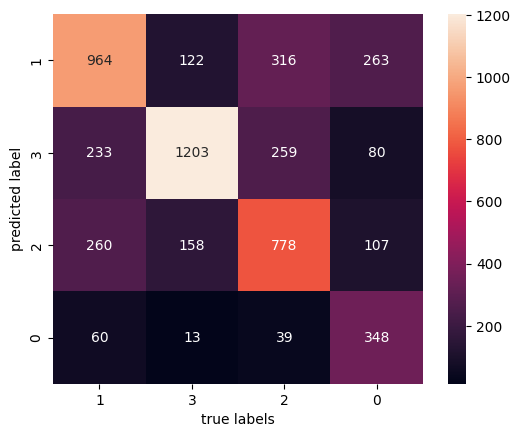


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.44      0.55       798
           1       0.58      0.64      0.61      1517
           2       0.60      0.56      0.58      1392
           3       0.68      0.80      0.74      1496

    accuracy                           0.63      5203
   macro avg       0.65      0.61      0.62      5203
weighted avg       0.64      0.63      0.63      5203





In [43]:
for model_name, model in models.items():
    cm17, cr17,acc17 = evaluate_aug17(model,1, X_train, y_train, X_test, y_test,'Gpt2_Augmenter.csv')
    print(f"Model: {model_name}")
    print("Accuracy: {}".format(acc17))
    print("Confusion Matrix:")
    sns.heatmap(cm17.T, square = True, annot=True, fmt = "d", xticklabels=y_test.unique(), yticklabels=y_test.unique())
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()
    print("\nClassification Report:")
    print(cr17)
    print("\n")